In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# GPyTorch Regression Tutorial

### 目標
以下の関係の回帰をガウス過程により求める。

$$
    y = \sin (2\pi x) + \epsilon \\
    \epsilon \sim N(0, 0.04)
$$


In [3]:
# Set up training data

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [5]:
tlrain_x
train_y

tensor([ 0.0705,  0.1081, -0.0430,  0.3501, -0.0486,  0.4636,  0.2937,  0.7763,
         0.3900,  0.6616,  0.5587,  0.4859,  1.4225,  0.6185,  0.6092,  1.0674,
         0.9270,  0.8644,  0.9071,  1.2243,  0.9630,  0.6564,  1.0641,  0.9078,
         1.0319,  0.8558,  1.1844,  1.1217,  0.6805,  0.7326,  0.7689,  0.7705,
         1.0185,  0.8761,  0.9625,  0.9378,  0.6320,  0.7998,  0.5644,  0.8580,
         0.7294,  0.8245,  0.3987,  0.4434,  0.2981,  0.1346,  0.3104,  0.5246,
         0.1155, -0.1124,  0.3271,  0.0832,  0.1814, -0.0345, -0.2520, -0.2876,
        -0.1046, -0.6284, -0.5626, -0.2693, -0.3739, -0.4968, -0.8037, -0.4582,
        -0.9583, -0.4358, -1.0706, -0.5334, -0.9736, -0.8949, -1.1209, -0.9255,
        -0.6172, -1.0238, -1.1338, -0.6943, -1.2110, -1.1222, -1.1728, -1.0273,
        -0.6903, -1.0163, -0.8481, -0.7255, -0.7574, -0.6063, -0.9153, -0.7158,
        -0.6981, -0.7579, -0.8201, -0.4694, -0.3233, -0.2499, -0.6351, -0.5479,
        -0.3146, -0.2093, -0.0448,  0.05

In [6]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [12]:
model.named_parameters()


<generator object Module.named_parameters at 0x7fa7007fad58>

In [14]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: -0.082   lengthscale: 0.256   noise: 0.031
Iter 2/50 - Loss: -0.089   lengthscale: 0.280   noise: 0.034
Iter 3/50 - Loss: -0.089   lengthscale: 0.292   noise: 0.037
Iter 4/50 - Loss: -0.088   lengthscale: 0.290   noise: 0.040
Iter 5/50 - Loss: -0.087   lengthscale: 0.282   noise: 0.041
Iter 6/50 - Loss: -0.087   lengthscale: 0.274   noise: 0.041
Iter 7/50 - Loss: -0.088   lengthscale: 0.268   noise: 0.040
Iter 8/50 - Loss: -0.089   lengthscale: 0.266   noise: 0.039
Iter 9/50 - Loss: -0.090   lengthscale: 0.269   noise: 0.037
Iter 10/50 - Loss: -0.090   lengthscale: 0.273   noise: 0.036
Iter 11/50 - Loss: -0.090   lengthscale: 0.278   noise: 0.035
Iter 12/50 - Loss: -0.089   lengthscale: 0.281   noise: 0.035
Iter 13/50 - Loss: -0.089   lengthscale: 0.281   noise: 0.034
Iter 14/50 - Loss: -0.089   lengthscale: 0.279   noise: 0.035
Iter 15/50 - Loss: -0.090   lengthscale: 0.275   noise: 0.035
Iter 16/50 - Loss: -0.090   lengthscale: 0.271   noise: 0.036
Iter 17/50 - Loss

In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [20]:
observed_pred

MultivariateNormal(loc: torch.Size([51]))

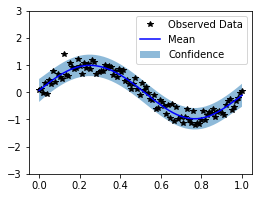

In [19]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [22]:
observed_pred.mean

tensor([ 0.0654,  0.1846,  0.3013,  0.4138,  0.5200,  0.6185,  0.7075,  0.7859,
         0.8526,  0.9067,  0.9477,  0.9750,  0.9886,  0.9885,  0.9749,  0.9481,
         0.9085,  0.8568,  0.7937,  0.7199,  0.6363,  0.5439,  0.4437,  0.3370,
         0.2251,  0.1093, -0.0088, -0.1275, -0.2452, -0.3600, -0.4701, -0.5735,
        -0.6685, -0.7533, -0.8263, -0.8860, -0.9312, -0.9610, -0.9747, -0.9720,
        -0.9529, -0.9179, -0.8679, -0.8038, -0.7271, -0.6396, -0.5431, -0.4398,
        -0.3317, -0.2213, -0.1106])

In [24]:
f_pred = model(test_x)

In [27]:
f_pred.confidence_region()

(tensor([-0.1088,  0.0447,  0.1859,  0.3133,  0.4268,  0.5277,  0.6171,  0.6956,
          0.7626,  0.8177,  0.8599,  0.8886,  0.9034,  0.9042,  0.8910,  0.8644,
          0.8248,  0.7731,  0.7099,  0.6362,  0.5527,  0.4605,  0.3606,  0.2541,
          0.1423,  0.0266, -0.0916, -0.2104, -0.3283, -0.4433, -0.5536, -0.6572,
         -0.7523, -0.8371, -0.9100, -0.9698, -1.0152, -1.0454, -1.0599, -1.0583,
         -1.0406, -1.0070, -0.9578, -0.8942, -0.8175, -0.7304, -0.6364, -0.5403,
         -0.4471, -0.3611, -0.2848], grad_fn=<SubBackward0>),
 tensor([ 0.2397,  0.3244,  0.4167,  0.5143,  0.6133,  0.7093,  0.7980,  0.8763,
          0.9426,  0.9958,  1.0354,  1.0614,  1.0739,  1.0729,  1.0588,  1.0318,
          0.9923,  0.9406,  0.8775,  0.8036,  0.7198,  0.6272,  0.5268,  0.4199,
          0.3078,  0.1920,  0.0740, -0.0446, -0.1621, -0.2767, -0.3865, -0.4898,
         -0.5848, -0.6696, -0.7426, -0.8023, -0.8473, -0.8766, -0.8895, -0.8856,
         -0.8652, -0.8289, -0.7779, -0.7134, -0